## Forecasting a Function
This notebook has been edited by Hróbjartur Höskuldsson (KU ID: VDH406)

In [ ]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
signal_length = 100
signal_repeats = 3
predict_ahead = 1
noise_strength = 0.00
total_series_length = signal_length * signal_repeats

Input: sinus signal $\sin(x_t)$

Target: same signal but predict\_ahead steps ($\delta$) shifted (predict to future) $ \sin(x_{t+\delta}) $

In [ ]:
dims = 1
def generateData(signal_length, predict_ahead, 
                 signal_repeats, batch_size, noise_strength):
    total_series_length = signal_length * signal_repeats
    time = np.linspace(
        0, np.pi*2*signal_repeats, 
        total_series_length + predict_ahead, dtype=np.float32
    )
    time = time.reshape((1, -1, 1))  
    
    # include shift for batches
    time = np.repeat(time, batch_size, 0)
    time += np.random.random(batch_size)[:, None, None] * 10
    y = np.sin(time)
    input_ = y[:, :total_series_length].copy()
    if noise_strength > 0:
        input_ += np.random.normal(size=(input_.shape)) * noise_strength # add some noise to the input
    target = y[:, predict_ahead:]
    return torch.tensor(input_) , torch.tensor(target)

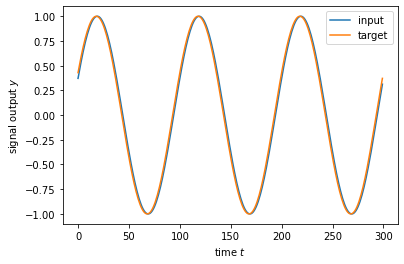

In [ ]:
x, y = generateData(
    signal_length, predict_ahead, signal_repeats, 1, noise_strength
)
x_i, y_i = x[0, :, 0], y[0, :, 0]
f, ax = plt.subplots(1)
ax.plot(x_i, label="input")
ax.plot(y_i, label="target")
ax.set_xlabel("time $t$")
ax.set_ylabel("signal output $y$")
ax.legend()

# Recurrent Neural Network (RNN)
**fully-connected-layer** is defined as:

$\mathbf{o} \leftarrow \sigma \left( W \cdot \mathbf{x} + \mathbf{b} \right)$
* activation function $\sigma$ (e.g. ReLU, tanH)
* weight matrix $W \in \mathbb{R}^{m \times d}$
* number of neurons $m$ and dimensionality $d$ of input $\mathbf{x} = (x_1 , \ldots , x_d)$
* bias vector $\mathbf{b}$
* output $\mathbf{o}$

**RNN-layer** is defined as:

$ \mathbf{o} \leftarrow \mathbf{h}_t \leftarrow \sigma \bigl( W \cdot \mathbf{x}_t +$ 
<font color=red> $ U \cdot \mathbf{h}_{t-1} $</font>
$ + \mathbf{b} \bigr) $

* the output $\mathbf{o}$ is also the hidden state $\mathbf{h}$ at time $t$
* input are time steps of the series: $\left( \ldots, \mathbf{x}_{t-1}, \mathbf{x}_{t},  \mathbf{x}_{t+1}, \ldots \right)$
* previous hidden state $h_{t-1}$ or the "memory" has its own weight matrix $U \in \mathbb{R}^{m \times m}$


## Simple Recurrent Networks (SRN)
 $\renewcommand{\hat}[1]{\widehat{#1}}$
**Elman network**: 
    
$ \mathbf{h}_t \leftarrow \sigma_h \bigl( W_h \cdot \mathbf{x}_t + U_h \cdot \mathbf{h}_{t-1} + \mathbf{b}_h \bigr) $

$ \hat{\mathbf{y}}_t \leftarrow \sigma_y \bigl( W_y \cdot \mathbf{h}_t + \mathbf{b}_y \bigr) $




## Creating a SRN model

In [ ]:
# use the hidden state (True) by activating learning for U_h
rnn_mode = True
# learn a better initial hidden state representation (True) than zero init
learn_h0 = True
# number of weight update iterations
n_iterations = 250
# size and stride of window for truncated backprop through time 
truncated_backprop_length = 10
# number of neurons m in the hidden layer
num_neurons = 8
batch_size = 5
lr = 0.01

device = "cpu"

In [ ]:
# first, define our model and initialize the learnable weights and biases (parameters):
class SRN(nn.Module):
    def __init__(self, dims, hidden_dims, learn_h0=False, 
                 activation=nn.Tanh, rnn_mode=True):
        super().__init__()
        self.activation = activation()
        
        # parameters of the (recurrent) hidden layer
        self.W_h = nn.Parameter(torch.randn(dims, hidden_dims, device=device) * .1)
        self.b_h = nn.Parameter(torch.zeros(1, hidden_dims, device=device))
        if rnn_mode:
            self.U_h = nn.Parameter(
                torch.randn(hidden_dims, hidden_dims, device=device) * .1
            )
        else:
            self.U_h = nn.Parameter(
                torch.zeros(hidden_dims, hidden_dims, device=device), 
                requires_grad=False # do not train the weights for the hidden state
            )

        # initial hidden state
        self.h_0 = nn.Parameter(
            torch.zeros(1, hidden_dims, device=device),
            requires_grad=learn_h0 # only train this if enabled
        )
        
        # output layer (fully connected)
        self.W_y = nn.Parameter(torch.randn(hidden_dims, dims, device=device) * .1)
        self.b_y = nn.Parameter(torch.zeros(1, dims, device=device))
                
    def step(self, x_t, h):
        #  forward pass for a single time step
        h = self.activation(
            torch.matmul(x_t, self.W_h) + torch.matmul(h, self.U_h) + self.b_h
        )
        return h # returning new hidden state

    def iterate_series(self, x, h):
        # apply rnn to each time step and give an output (many-to-many task)
        batch_size, n_steps, dimensions = x.shape
        
        hidden_states = []
        # iterate over time axis (1)
        for t in range(n_steps):
            # give previous hidden state and input from the current time step
            h = self.step(x[:, t], h)
            hidden_states.append(h)
        hidden_states = torch.stack(hidden_states, 1)
        
        # fully connected output
        y_hat = hidden_states.reshape(batch_size * n_steps, -1) # flatten steps and batch size (bs * )
        y_hat = torch.matmul(y_hat, self.W_y) + self.b_y
        y_hat = y_hat.reshape(batch_size, n_steps, -1) # regains structure
        return y_hat, hidden_states[:, -1]
    
    def forward(self, x, h):
        # x: b, t, d
        batch_size = x.shape[0] 
        if h is None:
            h = self.h_0.repeat_interleave(batch_size, 0)
        y_hat, h = self.iterate_series(x, h)
        return y_hat, h
    
    def auto_regression(self, x_0, h, steps):
        # one-to-many task (steps = \delta')
        x_prev = x_0
        y_hat = []
        # iterate over time axis (1)
        for t in range(steps):
            # give previous hidden state and input from the current time step
            h = self.step(x_prev, h)
            # here we need to apply the output layer on each step individually
            x_prev = torch.matmul(h, self.W_y) + self.b_y
            
            y_hat.append(x_prev)
        y_hat = torch.stack(y_hat, 1)
        return y_hat, h
    
    def many_to_one(self, x, h):
        
        # iterate over time axis
        for t in range(x.shape[1]):
            h = self.step(x[:, t], h)
        
        # last step prediction
        y_hat = torch.matmul(h, self.W_y) + self.b_y
        return y_hat, h
        
        
    def many_to_many_async(self, x, h, steps):
        y_hat = []

        for t in range(x.shape[1] -1):
          h = self.step(x[:, t], h)

        x_prev = x[:, -1]

        # iterate over time axis (1)
        for t in range(steps):
            # give previous hidden state and input from the current time step
            h = self.step(x_prev, h)
            # here we need to apply the output layer on each step individually
            x_prev = torch.matmul(h, self.W_y) + self.b_y
            y_hat.append(x_prev)
            
        y_hat = torch.stack(y_hat, 1)
        return y_hat, h

    

for backpropagation we use Adam, but we could use any optimizer from tf.keras.optimizer (or write our own)

In [ ]:
rnn = SRN(
    dims, num_neurons, 
    learn_h0=learn_h0, activation=nn.Tanh, 
    rnn_mode=rnn_mode
)
rnn.to(device)

# standard optimizer SGD or AdaGrad would also work
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

## Training the model

In [ ]:
# just a helper function to see the progress
def replot(input_series, predictions_series, batchY, iteration, loss):
    f, ax = plt.subplots(2, 2, figsize=(15, 7.5))
    steps = range(total_series_length)
    # show prediction
    ax[1, 1].plot(steps, batchY, color="blue", label="target $y$")
    ax[1, 1].plot(steps, predictions_series, color="red", label="prediction $\haty$")
    ax[1, 1].plot(steps, input_series, color="green", label="input $x$")
    ax[1, 1].text(0, 1, f"Iteration: {iteration} Loss: {loss[-1]}", )
    ax[1, 1].set_ylabel("value")
    ax[1, 1].set_xlabel("steps")
    ax[1, 1].set_title("current prediction")
    ax[1, 1].legend(loc='upper right')
    
    # show prediction (zoomed in)
    ax[1, 0].plot(
        steps[-signal_length:], batchY[-signal_length:], 
        color="blue", label="target $y$"
    )
    ax[1, 0].plot(
        steps[-signal_length:], predictions_series[-signal_length:], 
        color="red", label="prediction $\haty$"
    )
    ax[1, 0].plot(
        steps[-signal_length:], input_series[-signal_length:], 
        color="green", label="input $x$"
    )
    ax[1, 0].set_ylabel("value")
    ax[1, 0].set_xlabel("steps")
    ax[1, 0].set_title("current prediction (zoomed in)")
    ax[1, 0].legend(loc='upper right')

    # show errors (zoomed in)
    ax[0, 0].plot(
        steps[-signal_length:], 
        batchY[-signal_length:] - predictions_series[-signal_length:], 
        color="blue", label="errors $y$"
    )
    ax[0, 0].set_ylabel("residual")
    ax[0, 0].set_xlabel("steps")
    ax[0, 0].set_title("errors (zoomed in)")
    ax[0, 0].legend(loc='upper right')
    
    # show training loss
    ax[0, 1].plot(range(iteration), loss, color="blue", label="loss")
    ax[0, 1].set_title("training loss")
    ax[0, 1].legend(loc='upper right')
    ax[0, 1].set_yscale("log")
    ax[0, 1].set_ylabel("loss")
    ax[0, 1].set_xlabel("iteration")
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)

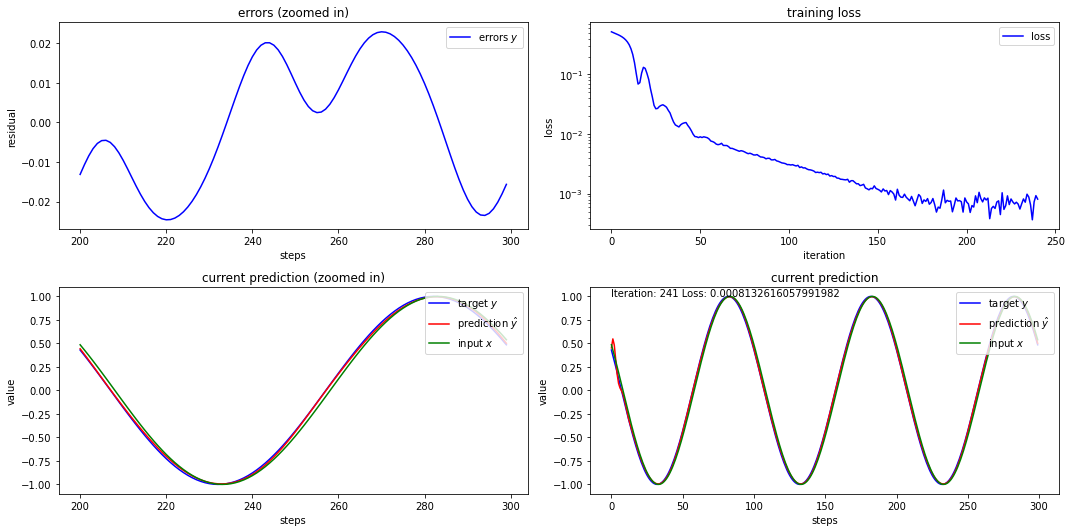

In [ ]:
rnn.train()
iteration = 0
# how often we plot the prediction
log_iter = 10
iter_loss = []

# train for a set number of iterations
for iteration in range(n_iterations):
    # generates a long time series / normally loaded from dataset (e.g. stocks, weather)
    x, y = generateData(
        signal_length, predict_ahead, signal_repeats, batch_size, noise_strength
    )
    x, y = x.to(device), y.to(device)
    h = None
    # reset gradients
    optimizer.zero_grad()
    
    y_hat = []
    # do not feed complete series, but windows (truncated_backprop_length)
    for i in range(0, total_series_length, truncated_backprop_length):
        # create chunks of input/target data with our defined truncated backprop length
        x_part = x[:, i: i + truncated_backprop_length]

        # get predictions for this part (forward pass)
        y_hat_part, h = rnn(x_part, h)
        
        # add to previous predictions
        y_hat.append(y_hat_part)

        # detach hidden_state from computational graph
        h = h.detach()
    
    # combine predictions
    y_hat = torch.cat(y_hat, 1)
        
    # calculate mean squared error
    loss = torch.mean((y_hat - y)**2)        
    # backprop
    loss.backward()
    
    # finally we are adapting the weights with the saved gradient information
    optimizer.step()
    # log loss
    iter_loss.append(loss.item())
    
    # plot model predictions during training
    if iteration % log_iter == 0:
        replot(x[0].cpu(), y_hat[0].detach().cpu(), y[0].cpu(), iteration + 1, iter_loss)


# Free Running RNN (Generating) or Auto-Regressive Prediction
to make continous predictions 

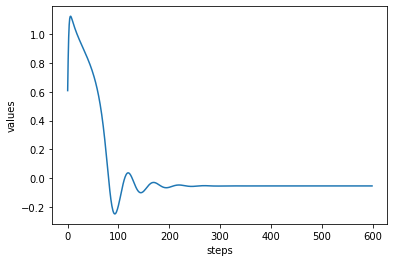

In [ ]:
rnn.eval()
with torch.no_grad():
    batch_s = 1
    # initialize hidden state (h_0) with zeros
    h_ar = rnn.h_0.repeat_interleave(batch_s, 0)

    # initial (single) value for x
    x_0 = torch.rand(batch_s, 1) * 2 - 1 # between -1 and 1
    x_0 = x_0.to(device)
    
    # any length possible here
    length = total_series_length * 2
    # get predictions for "lenght" time steps (can be seen as forecast that is as long as the defined length)
    y_hat, h_ar = rnn.auto_regression(x_0, h_ar, length)

    f, ax = plt.subplots(1)
    ax.set_xlabel('steps')
    ax.set_ylabel('values')
    ax.plot(y_hat[0, :, 0].cpu())


# Continuation of a signal (many-to-many)
can be used to forecast many steps ahead

the red and blue line should align, the error should be around 0.007

MSE: 0.5092889070510864


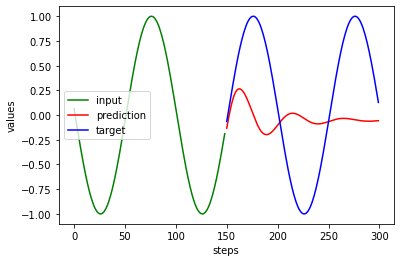

In [ ]:
rnn.eval()
with torch.no_grad():
    batch_s = 1
    # initialize hidden state (h_0) with zeros
    h_ar = rnn.h_0.repeat_interleave(batch_s, 0)

    # initial values for x
    x_full, _ = generateData(
        signal_length, predict_ahead, signal_repeats, batch_s, noise_strength
    )
    x_full = x_full.to(device)
    split_point = total_series_length//2
    
    x = x_full[:, :split_point - predict_ahead]
    y = x_full[:, split_point:]
    
    # any length possible here
    length = y.size(1)
    # get predictions for "lenght" time steps (can be seen as forecast that is as long as the defined length)
    y_hat, h_ar = rnn.many_to_many_async(x, h_ar, length)

    # show forecast
    f, ax = plt.subplots(1)
    ax.set_xlabel('steps')
    ax.set_ylabel('values')
    ax.plot(
        range(split_point - predict_ahead), x[0, :, 0].cpu(), 
        c="green", label="input")
    ax.plot(
        range(split_point, total_series_length), 
        y_hat[0, :, 0].cpu(), c="red", label="prediction"
    )
    ax.plot(
        range(split_point, total_series_length), 
        y[0, :, 0].cpu(), c="blue", label="target"
    )
    plt.legend()
    
    # print error:
    print(f"MSE: {((y_hat - y)**2).mean()}")


# many-to-one test
the scatter points should nearly align and the error should be around 0.0002

MSE: 3.148602263536304e-05


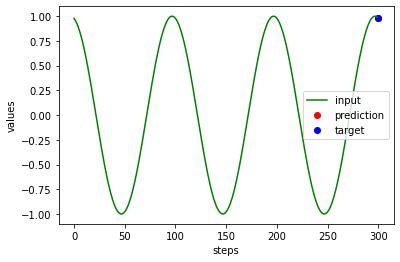

In [ ]:
rnn.eval()
with torch.no_grad():
    batch_s = 1
    # initialize hidden state (h_0) with zeros
    h_ar = rnn.h_0.repeat_interleave(batch_s, 0)

    # initial values for x
    x, y = generateData(
        signal_length, predict_ahead, signal_repeats, batch_s, noise_strength
    )
    y = y[:, -1] # change the task to many-to-one
    x = x.to(device)
    y = y.to(device)

    # get predictions for "lenght" time steps (can be seen as forecast that is as long as the defined length)
    y_hat, h_ar = rnn.many_to_one(x, h_ar)

    # show forecast
    f, ax = plt.subplots(1)
    ax.set_xlabel('steps')
    ax.set_ylabel('values')
    ax.plot(
        range(total_series_length), x[0, :, 0].cpu(), 
        c="green", label="input")
    ax.scatter(
        total_series_length, 
        y_hat[0, 0].cpu(), c="red", label="prediction"
    )
    ax.scatter(
        total_series_length, 
        y[0, 0].cpu(), c="blue", label="target"
    )
    plt.legend()
    
    # print error:
    print(f"MSE: {((y_hat - y)**2).mean()}")
